# New York City Taxi Fare Prediction
This notebook is dedicated to practicing the techniques from [fastai chapter 6](https://course.fast.ai/Lessons/lesson6.html) on the [new york taxi fare dataset](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction)

In [2]:
# Install stuff
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastai.vision.all import *
from fastbook import *

In [4]:
# Download the data
path = Path('new-york-city-taxi-fare-prediction')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.56G/1.56G [01:00<00:00, 27.6MB/s]


In [3]:
import pandas as pd

chunksize = 100000 
chunks = pd.read_csv("new-york-city-taxi-fare-prediction/train.csv", chunksize=chunksize)

chunk_list = []
for chunk in chunks:
    chunk_list.append(chunk)

print(len(chunk_list))

555


In [50]:
chunk_list[0].head(), chunk_list[-1].head()

(                             key  fare_amount          pickup_datetime  \
 0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
 1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
 2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
 3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
 4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
 
    pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
 0        -73.844311        40.721319         -73.841610         40.712278   
 1        -74.016048        40.711303         -73.979268         40.782004   
 2        -73.982738        40.761270         -73.991242         40.750562   
 3        -73.987130        40.733143         -73.991567         40.758092   
 4        -73.968095        40.768008         -73.956655         40.783762   
 
    passenger_count  
 0                1  
 1                1  
 2          

The data doesn't seem to be ordered as a time series so I think I can just refine my model and data processing using a single chunk and then try training the final model using the full data set.

In [51]:
import random

df = chunk_list[random.randint(1, len(chunk_list))]

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 54100000 to 54199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                100000 non-null  object 
 1   fare_amount        100000 non-null  float64
 2   pickup_datetime    100000 non-null  object 
 3   pickup_longitude   100000 non-null  float64
 4   pickup_latitude    100000 non-null  float64
 5   dropoff_longitude  100000 non-null  float64
 6   dropoff_latitude   100000 non-null  float64
 7   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 6.1+ MB


In [53]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.424589,-72.464131,39.882988,-72.420383,39.892987,1.682590
std,9.938708,11.905800,14.232009,14.626739,6.825288,1.304537
min,-90.000000,-1614.679270,-3111.708827,-787.633332,-74.012983,0.000000
25%,6.000000,-73.992067,40.734633,-73.991443,40.733647,1.000000
50%,8.500000,-73.981770,40.752495,-73.980190,40.752969,1.000000
75%,12.500000,-73.966842,40.767007,-73.963667,40.768002,2.000000
max,315.000000,40.783237,2546.155107,3017.210895,901.980773,6.000000


I like this data set so far as their are not a whole lot of columns to deal with.

It looks like there are some missing values in the dropoff location. I'll leave it for now until I take a better look at the data.

In [54]:
from fastai.tabular.all import *

# Add some date-time metadata
train_df = add_datepart(df, 'pickup_datetime')
train_df.info()

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 54100000 to 54199999
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   key                              100000 non-null  object 
 1   fare_amount                      100000 non-null  float64
 2   pickup_longitude                 100000 non-null  float64
 3   pickup_latitude                  100000 non-null  float64
 4   dropoff_longitude                100000 non-null  float64
 5   dropoff_latitude                 100000 non-null  float64
 6   passenger_count                  100000 non-null  int64  
 7   pickup_datetimeYear              100000 non-null  int32  
 8   pickup_datetimeMonth             100000 non-null  int32  
 9   pickup_datetimeWeek              100000 non-null  int32  
 10  pickup_datetimeDay               100000 non-null  int32  
 11  pickup_datetimeDayofweek         100000 non-null  int32 

In [55]:
dep_var = "fare_amount"
cont, cat = cont_cat_split(train_df, 1, dep_var=dep_var)
procs = [Categorify, FillMissing]
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs, cat, cont, y_names=dep_var, splits=splits)

print(f"Training set length: {len(to.train)}")
print(f"Validation set length: {len(to.valid)}")

Training set length: 80000
Validation set length: 20000


In [56]:
print(cont, cat)
print(to.items.isna().sum())

['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetimeYear', 'pickup_datetimeMonth', 'pickup_datetimeWeek', 'pickup_datetimeDay', 'pickup_datetimeDayofweek', 'pickup_datetimeDayofyear', 'pickup_datetimeElapsed'] ['key', 'pickup_datetimeIs_month_end', 'pickup_datetimeIs_month_start', 'pickup_datetimeIs_quarter_end', 'pickup_datetimeIs_quarter_start', 'pickup_datetimeIs_year_end', 'pickup_datetimeIs_year_start']
key                                0
fare_amount                        0
pickup_longitude                   0
pickup_latitude                    0
dropoff_longitude                  0
dropoff_latitude                   0
passenger_count                    0
pickup_datetimeYear                0
pickup_datetimeMonth               0
pickup_datetimeWeek                0
pickup_datetimeDay                 0
pickup_datetimeDayofweek           0
pickup_datetimeDayofyear           0
pickup_datetimeIs_month_end        0
pickup

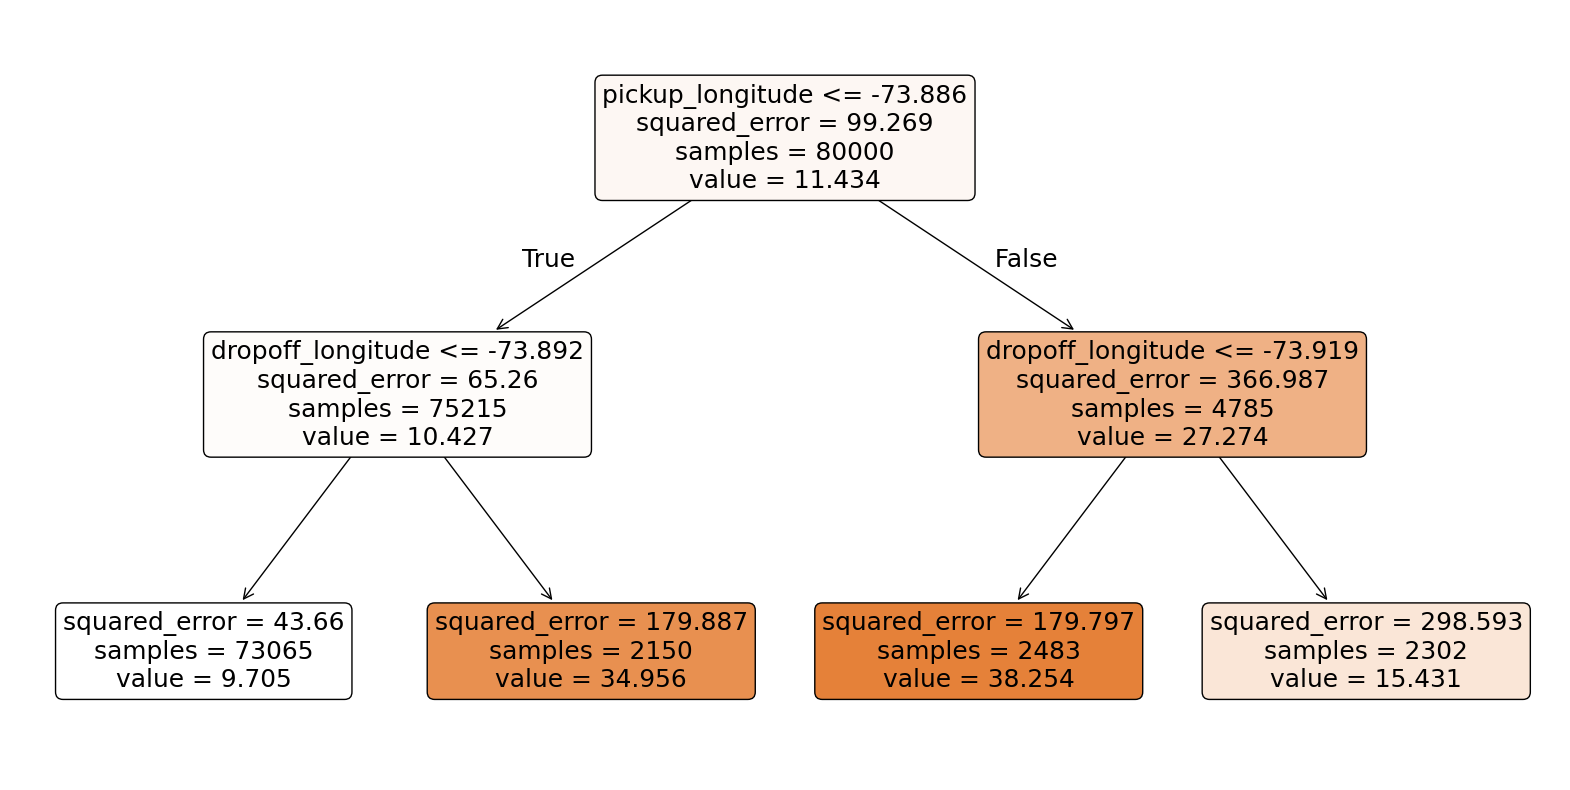

In [57]:
from sklearn.tree import DecisionTreeRegressor

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

def show_tree(tree, feature_names):
    plt.figure(figsize=(20,10))
    plot_tree(tree, filled=True, rounded=True, feature_names=feature_names)
    plt.show()

show_tree(m, feature_names=xs.columns)

In [58]:
!pip install dtreeviz

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


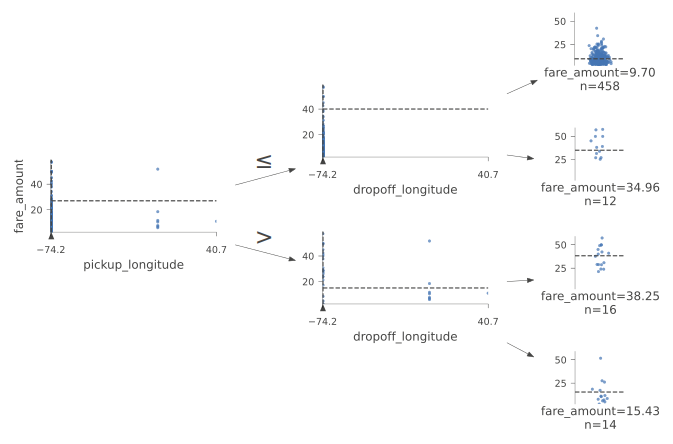

In [59]:
from dtreeviz.trees import *
samp_idx = np.random.permutation(len(y))[:500]

viz_model=model(m,
                         X_train=xs.iloc[samp_idx],
                         y_train=y.iloc[samp_idx],
                         feature_names=xs.columns,
                         target_name=dep_var)

viz_model.view(fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
               orientation='LR')


It looks like there is something weird going on with the pickup_longitude. I'm going to dig into this more but first let's get a baseline accuracy and submission

In [62]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true) ** 2))

In [63]:
train_preds = m.predict(xs)
valid_preds = m.predict(valid_xs)
rmse(y, train_preds), rmse(valid_y, valid_preds)

(7.673498457134854, 7.625395051266044)

In [80]:
# Get the test data and process it
test_df = pd.read_csv("new-york-city-taxi-fare-prediction/test.csv")
test_df = add_datepart(test_df, 'pickup_datetime')
to_test = to.train.new(test_df)
to_test.process()
test_xs = to_test.xs

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


In [81]:
test_df.info(), train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              9914 non-null   object 
 1   pickup_longitude                 9914 non-null   float64
 2   pickup_latitude                  9914 non-null   float64
 3   dropoff_longitude                9914 non-null   float64
 4   dropoff_latitude                 9914 non-null   float64
 5   passenger_count                  9914 non-null   int64  
 6   pickup_datetimeYear              9914 non-null   int32  
 7   pickup_datetimeMonth             9914 non-null   int32  
 8   pickup_datetimeWeek              9914 non-null   int32  
 9   pickup_datetimeDay               9914 non-null   int32  
 10  pickup_datetimeDayofweek         9914 non-null   int32  
 11  pickup_datetimeDayofyear         9914 non-null   int32  
 12  pickup_datetimeIs_mo

(None, None)

### Note
I was running the note book previously and some of the chunks have missing drop off location data. TabularPandas didn't seem to be handling it properly and this was causing an issue with the cell above.

Will dig into this later when I have to train on the whole data set.

## Baseline Submission

In [82]:
test_xs.info(), xs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   key                              9914 non-null   int32  
 1   pickup_datetimeIs_month_end      9914 non-null   int8   
 2   pickup_datetimeIs_month_start    9914 non-null   int8   
 3   pickup_datetimeIs_quarter_end    9914 non-null   int8   
 4   pickup_datetimeIs_quarter_start  9914 non-null   int8   
 5   pickup_datetimeIs_year_end       9914 non-null   int8   
 6   pickup_datetimeIs_year_start     9914 non-null   int8   
 7   pickup_longitude                 9914 non-null   float64
 8   pickup_latitude                  9914 non-null   float64
 9   dropoff_longitude                9914 non-null   float64
 10  dropoff_latitude                 9914 non-null   float64
 11  passenger_count                  9914 non-null   int64  
 12  pickup_datetimeYear 

(None, None)

In [83]:
test_preds = m.predict(test_xs)
submission = pd.DataFrame({
    'key': test_df['key'],
    'fare_amount': test_preds
})
submission.to_csv("baseline.csv", index=False)
submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.704826
1,2015-01-27 13:08:24.0000003,9.704826
2,2011-10-08 11:53:44.0000002,9.704826
3,2012-12-01 21:12:12.0000002,9.704826
4,2012-12-01 21:12:12.0000003,9.704826
